In [15]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.ndimage import gaussian_filter, label
from scipy.ndimage import center_of_mass
from sklearn.metrics import silhouette_score
import plotly.express as px
import sys
import pygmt
import pandas as pd
# sys.path.append('/Volumes/envisat2/SWOT/src/lib_sio/')
# sys.path.append('/Volumes/envisat2/SWOT/src/SWOT-OpenToolkit-main/src/')
# sys.path.append('/cryosat2/SWOT/src/lib_sio/')
# import swot_ssh_utils as swot
# import swot_sio_utils as sio
import scipy.signal
import random
import scipy.stats as st
from scipy.ndimage import sobel

In [2]:
# Load the GRD file using xarray
file_path = 'vgg_seamount_SWOT.grd'
dataset = xr.open_dataset(file_path, engine='netcdf4')
# Extract data
longitude = dataset['lon'].values
latitude = dataset['lat'].values
elevation = dataset['z'].values

# Smooth the data to reduce noise
smoothed_elevation = gaussian_filter(elevation, sigma=1.2)

# Compute the gradient of the smoothed elevation data
gradient_x = sobel(smoothed_elevation, axis=0)
gradient_y = sobel(smoothed_elevation, axis=1)
gradient_magnitude = np.hypot(gradient_x, gradient_y)

# Combine the gradient and elevation data to find peaks with high gradients
combined_data = smoothed_elevation * gradient_magnitude

# Threshold the combined data to find peaks
threshold = np.percentile(combined_data, 95)# Adjust this value if needed
binary_peaks = combined_data > threshold

# Label the connected regions (peaks)
labeled_peaks, num_features = label(binary_peaks)

# Find the center of mass of each labeled region (seamount)
seamounts = center_of_mass(combined_data, labeled_peaks, range(1, num_features + 1))

# Extract the locations of the seamounts
seamount_locations = [(longitude[round(y)], latitude[round(x)]) for x, y in seamounts]


In [3]:
def mark_seamounts(dataset: xr.Dataset, threshold: float):
    longitude = dataset['lon'].values
    latitude = dataset['lat'].values
    elevation = dataset['z'].values

    # Smooth the data to reduce noise
    smoothed_elevation = gaussian_filter(elevation, sigma=1.2)

    # Compute the gradient of the smoothed elevation data
    gradient_x = sobel(smoothed_elevation, axis=0)
    gradient_y = sobel(smoothed_elevation, axis=1)
    gradient_magnitude = np.hypot(gradient_x, gradient_y)

    # Combine the gradient and elevation data to find peaks with high gradients
    combined_data = smoothed_elevation * gradient_magnitude

    # Threshold the combined data to find peaks
    threshold = np.percentile(combined_data, threshold) # FIXME: Percentile is a bad way to do this - areas with very few seamounts will get 
    # assigned a large number of seamounts while areas with many seamounts will get assigned a small number of seamounts (over and under predicting the acual number of seamounts)
    binary_peaks = combined_data > threshold

    # Label the connected regions (peaks)
    labeled_peaks, num_features = label(binary_peaks)  # TODO: Label accepts custom structures - perhaps we can make our own? This should reduce the overlap of predicted seamounts

    # Find the center of mass of each labeled region (seamount)
    seamounts = center_of_mass(combined_data, labeled_peaks, range(1, num_features + 1))

    # Extract the locations of the seamounts
    seamount_locations = [(longitude[int(y)], latitude[int(x)]) for x, y in seamounts]
    return seamount_locations

In [53]:
seamount_frame = dataset.to_dataframe()
seamount_frame['predicted'] = np.zeros(len(seamount_frame))
lon_lat_array = seamount_frame.reset_index()[['lon', 'lat']].to_numpy()
seamount_frame

z  predicted
lon        lat                           
-97.991667 -6.791667  0.483092        0.0
           -6.775000 -1.329656        0.0
           -6.758333 -2.035961        0.0
           -6.741667 -1.874481        0.0
           -6.725000 -1.791726        0.0
...                        ...        ...
-89.008333 -2.075000 -3.987018        0.0
           -2.058333 -4.519841        0.0
           -2.041667 -4.998114        0.0
           -2.025000 -6.230206        0.0
           -2.008333 -8.005533        0.0

[155520 rows x 2 columns]

In [54]:
test_vals = np.linspace(90, 99, 100)
num_predicted = []
for val in test_vals:
    seamount_locations = mark_seamounts(dataset, val)
    # Create an array of labels for each point in the dataset
    local_seamount_frame = seamount_frame.copy()
    for lon, lat in seamount_locations:
        local_seamount_frame.loc[(lon, lat), 'predicted'] = 1
    labels = local_seamount_frame['predicted'].to_numpy()
    # Use the labels array for further processing
    num_predicted.append([val, silhouette_score(lon_lat_array, labels)])
px.scatter(pd.DataFrame(num_predicted), x=0, y=1).show()

In [55]:
seamount_locations = mark_seamounts(dataset, 94.18182)

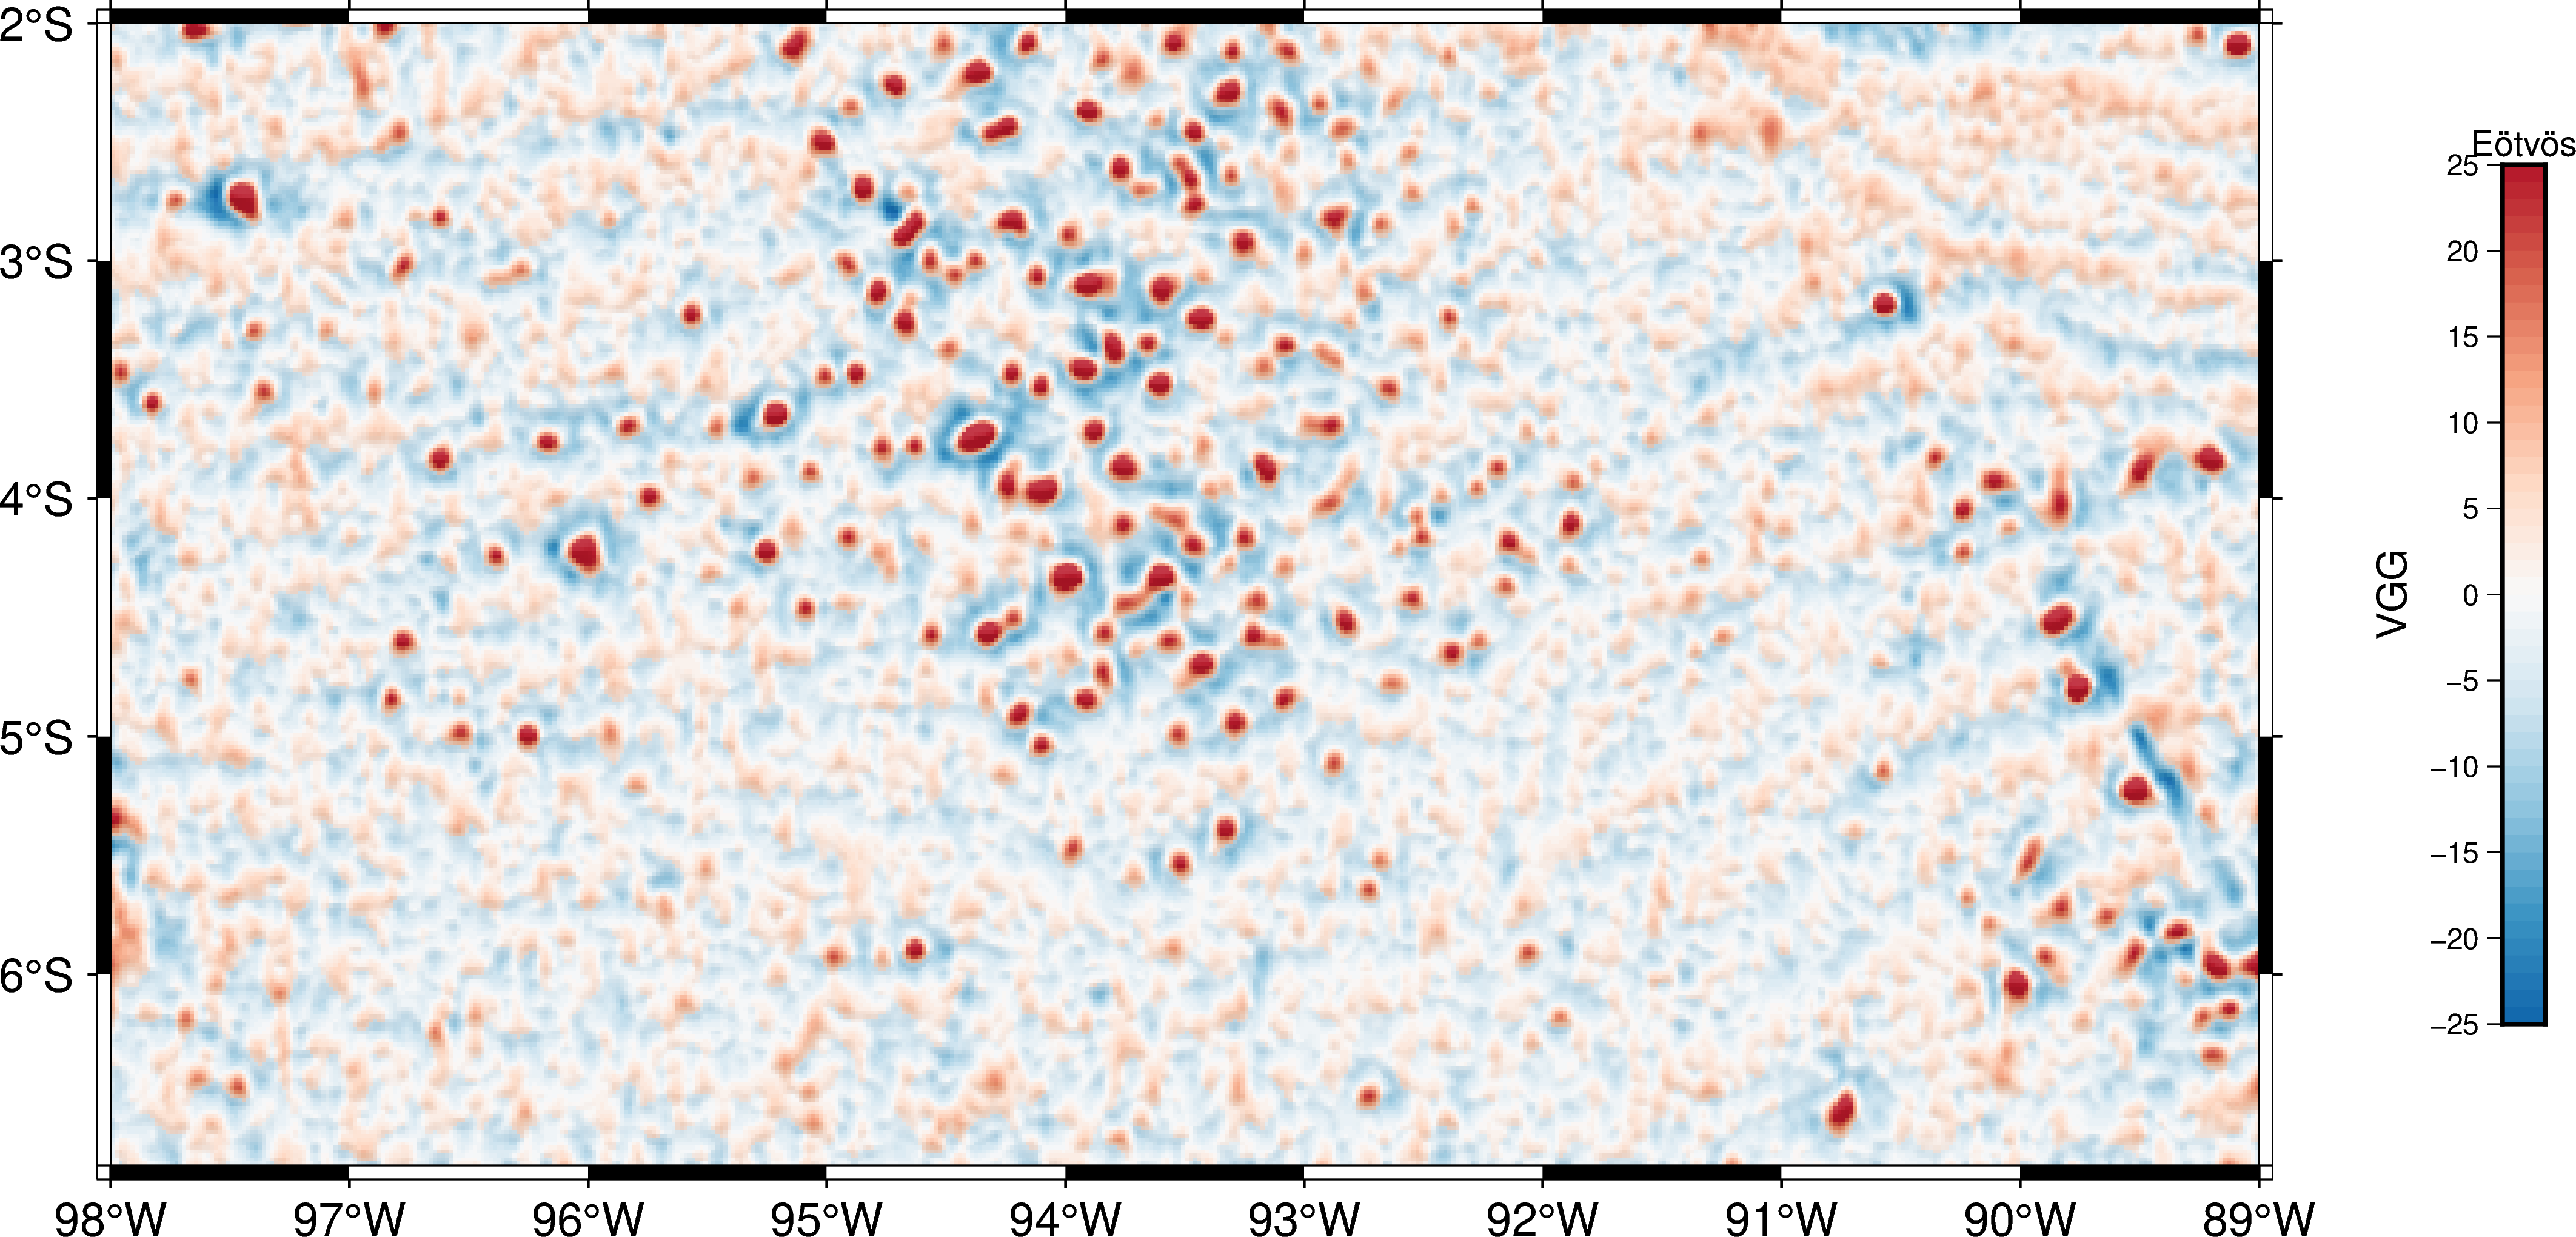

In [56]:
vgg_file = xr.open_dataset("vgg_seamount_SWOT.grd")
vgg_seamounts = vgg_file.sel(lon=slice(-98, -89), lat=slice(-6.8, -2))
shade_vgg = pygmt.grdgradient(grid=xr.DataArray(vgg_seamounts.z, coords=(vgg_seamounts.lat, vgg_seamounts.lon)), azimuth = 0, normalize="t.2")

fig = pygmt.Figure()
pygmt.makecpt(cmap="colors.cpt", series=[-25, 25, 1], background='o')
fig.grdimage(
    grid = xr.DataArray(vgg_seamounts.z, coords=(vgg_seamounts.lat, vgg_seamounts.lon)),
    shading = shade_vgg,
    projection="M15c",
    region = [-98, -89, -6.8, -2],
    frame=["WSrt+t", "xa1", "ya1"],
    cmap = True,
    )

fig.colorbar(position="JML+o-17c/0c+w6c/0.3c", frame=["xa5f5+lVGG", "y+lEötvös"])
# fig.savefig("SWOT_seamounts_shading.pdf", dpi=600)
fig.show(dpi=600)

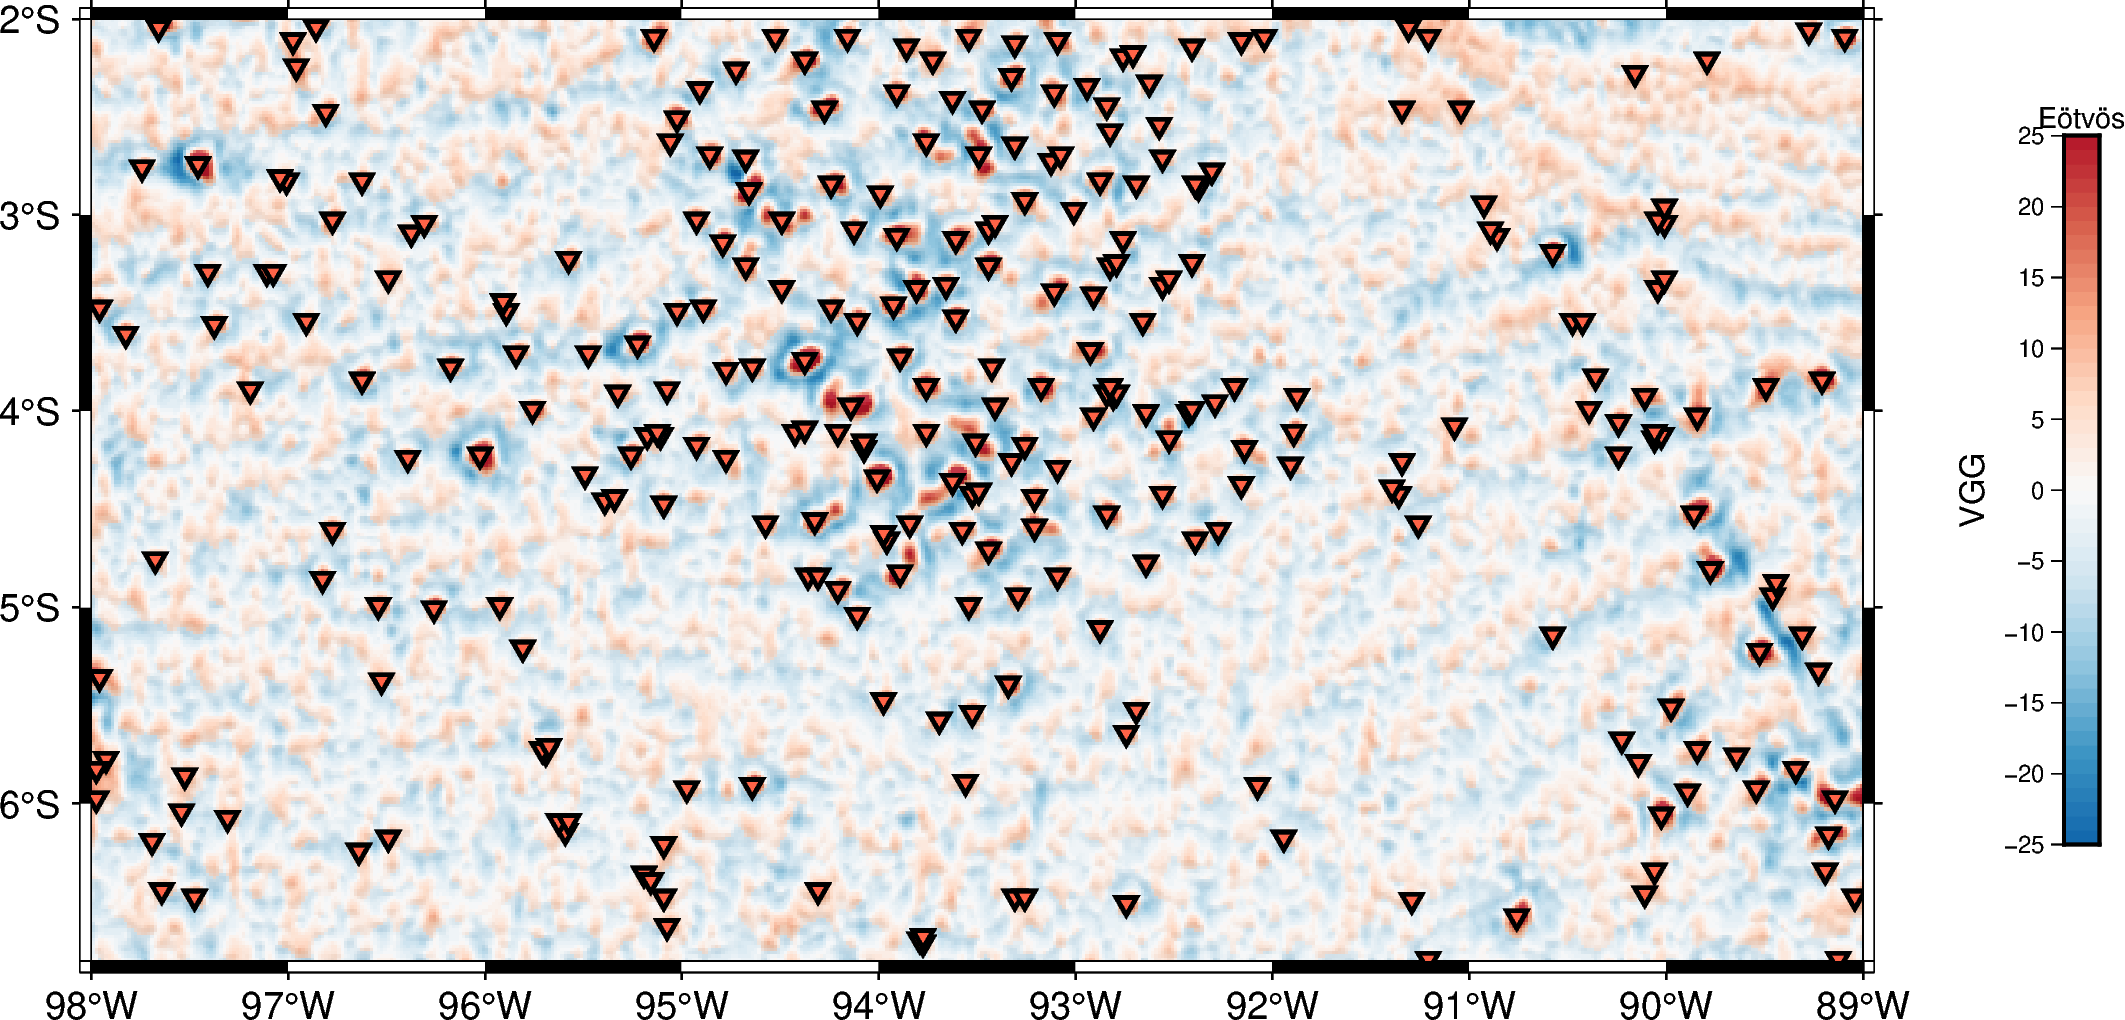

In [57]:
vgg_file = xr.open_dataset("vgg_seamount_SWOT.grd")
vgg_seamounts = vgg_file.sel(lon=slice(-98, -89), lat=slice(-6.8, -2))
shade_vgg = pygmt.grdgradient(grid=xr.DataArray(vgg_seamounts.z, coords=(vgg_seamounts.lat, vgg_seamounts.lon)), azimuth = 0, normalize="t.2")

fig = pygmt.Figure()
pygmt.makecpt(cmap="colors.cpt", series=[-25, 25, 1], background='o')
fig.grdimage(
    grid = xr.DataArray(vgg_seamounts.z, coords=(vgg_seamounts.lat, vgg_seamounts.lon)),
    shading = shade_vgg,
    projection="M15c",
    region = [-98, -89, -6.8, -2],
    frame=["WSrt+t", "xa1", "ya1"],
    cmap = True,
    )

fig.colorbar(position="JML+o-17c/0c+w6c/0.3c", frame=["xa5f5+lVGG", "y+lEötvös"])
for lon, lat in seamount_locations:
    # plt.plot(lon, lat, 'k.',markersize=2, markerfacecolor='none')  # black circles for seamount locations
    fig.plot(x=lon, y=lat, style="i0.2c", pen="1p,black", fill="tomato")



fig.show()